In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import torch
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, Sigmoid
import torch.nn.functional as F
from tukey import losses
from tukey.transforms import SoftPlusTransform

## Definition of neural network 

For this simulated data experiments, we use a simple neural network with a few dense layers. Note that the transformations that ensure that the outputs of the neural network are in the correct domain (i.e. positive for $\sigma$ and $h$ are in the loss class, not directly in the neural network.

In [2]:
class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), ReLU(), ]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]

nn = NN((1, 512, 512, 512), 4)  # 4 outputs required for G-and-H
nn_gaussian = NN((1, 512, 512, 512), 2)  # 2 outputs required for Gaussian

## Definition of the true model and simulation 

For our simulation study, we consider a very simple regression problem of a scalar target $Y$ in terms of a scalar feature $X$. The true conditional distribution of $Y$ given $X$ is defined according to the following equation,

\begin{equation}
    Y | X \sim \mu(X) + \sigma(X) \tau_{g(X), h(X)}(Z),
\end{equation}
where the functions $\mu(\cdot)$, $\sigma(\cdot)$, $g(\cdot)$ and $h(\cdot)$ are defined arbitrarily --- see the functioon $f$ defined in the code portion below. The random variable $Z$ is standard normal, $Z\sim\mathcal{N}(0, 1)$, while $\tau_{g,h}$ is the tukey $g$ and $h$ transform.

For our simulations we sample $X$ according to a uniform distribution on the interval $[0, 1]$.

<IPython.core.display.Javascript object>


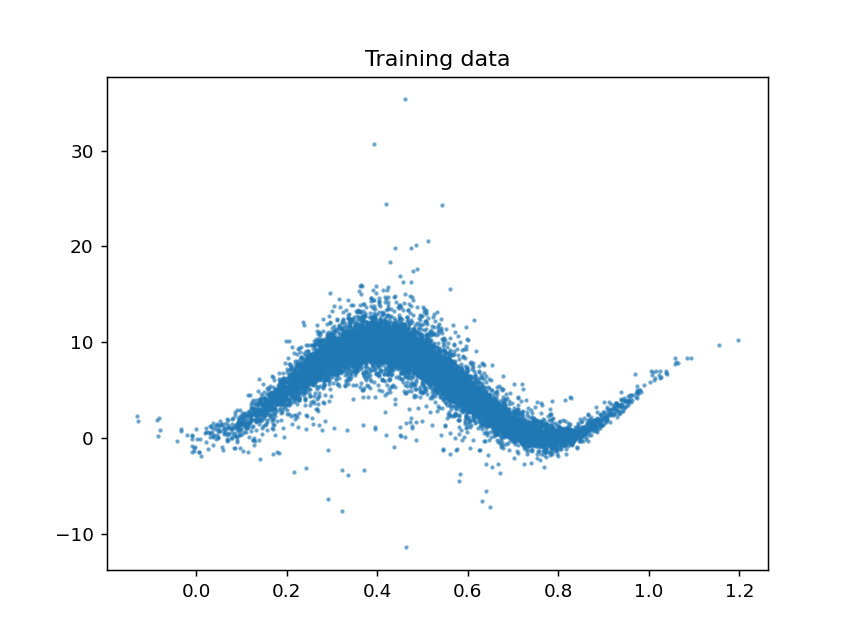

In [3]:
def f(x: float) -> tuple:
    """Function providing the 4 parameters (mu, beta, g, h) of the transformation applied to 
    a standard normal variable given the input x. Chosen arbitrarily for the simulation.
    """
    return 10 * np.sin(4 * x) ** 2, 1 + 3 * (x - 0.25)**2, 1 / 2 * (x - 0.5), np.maximum(0, 0.25 - (x - 0.5)**2)

def tukey_g_h(z: float, theta: tuple):
    """Applies the tukey-g-h transform with parameters theta to z."""
    mu, beta, g, h = theta
    z_tilda = 1 / g * (np.exp(g * z) - 1) * np.exp(h * z**2 / 2)
    return mu + 1 / beta * z_tilda

def t_dist(x: float):
    return t(df = 3 * x + 3, loc = 4 * x**2, scale = 0.2 + (x - 0.5)**2).rvs(10000)


n_samples = 20000
train_split = int(n_samples * 0.8)

x_data = np.random.randn(n_samples).astype(np.float32) / 6 + 0.5
theta = f(x_data)

z = np.random.randn(n_samples).astype(np.float32)
y_data = tukey_g_h(z, theta)

x_data, x_data_val = x_data[:train_split], x_data[train_split:]
y_data, y_data_val = y_data[:train_split], y_data[train_split:]

#y_data = t_dist(x_data)

%matplotlib notebook
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_data, y_data, s=2, alpha=0.5)
_ = ax.set_title('Training data')

## Training 

In [4]:
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

BATCH_SIZE = 128
N_EPOCHS=25

loss = losses.TuckeyGandHloss(n_target_channels=1)
loss_gaussian = losses.GaussianLoss(n_target_channels=1)
nn_parameters = nn.parameters()
nn_gaussian_parameters = nn_gaussian.parameters()

x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data).reshape((-1, 1))
x_val_torch, y_val_torch = torch.tensor(x_data_val).reshape((-1, 1)), torch.tensor(y_data_val).reshape((-1, 1))

dataset = TensorDataset(x_torch, y_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch)
optimizer = Adam(nn_parameters, lr=1e-4)
optimizer_gaussian = Adam(nn_gaussian_parameters, lr=1e-4)

In [5]:
def train_for_one_epoch(nn, dataset):
    nn.train()
    nn_gaussian.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
        # gaussian
        optimizer_gaussian.zero_grad()
        y_hat = nn_gaussian(x)
        loss_y_yhat = loss_gaussian(y_hat, y)
        loss_y_yhat.backward()
        optimizer_gaussian.step()
        losses_gaussian.append(loss_y_yhat.detach().item())
    print('Train losses: ', np.mean(losses), np.mean(losses_gaussian))
    
    nn.eval()
    nn_gaussian.eval()
    dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            losses.append(loss_y_yhat.detach().item())
            y_hat = nn_gaussian(x)
            loss_y_yhat = loss_gaussian(y_hat, y)
            losses_gaussian.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(losses), np.mean(losses_gaussian))
            



for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch(nn, dataset)

Train losses:  3.054482407569885 3.193559720993042
Validation losses:  2.0090743601322174 2.0864090099930763
Train losses:  1.7972660455703735 1.8213282146453857
Validation losses:  1.6968540959060192 1.6603015214204788
Train losses:  1.6085158910751343 1.4771717052459716
Validation losses:  1.4725737795233727 1.2055574283003807
Train losses:  1.257304825782776 1.0104045100212098
Validation losses:  0.9928561765700579 0.8655700702220201
Train losses:  0.8392899026870727 0.8699543719291687
Validation losses:  0.7339380588382483 0.8027413468807936
Train losses:  0.6858015689849853 0.8179651188850403
Validation losses:  0.6702777091413736 0.751149358227849
Train losses:  0.6361222410202027 0.7880981335639954
Validation losses:  0.6296547614037991 0.7429690379649401
Train losses:  0.6108870685100556 0.7653594717979432
Validation losses:  0.6161234239116311 0.7333442233502865
Train losses:  0.6001696276664734 0.7622253699302673
Validation losses:  0.6106757372617722 0.7230668403208256
Train

## Analysis 

For analysis, we plot the 4 functions of $x$ that make up the true model (solid lines) and the values predicted by the neural network (dashed lines).

<IPython.core.display.Javascript object>


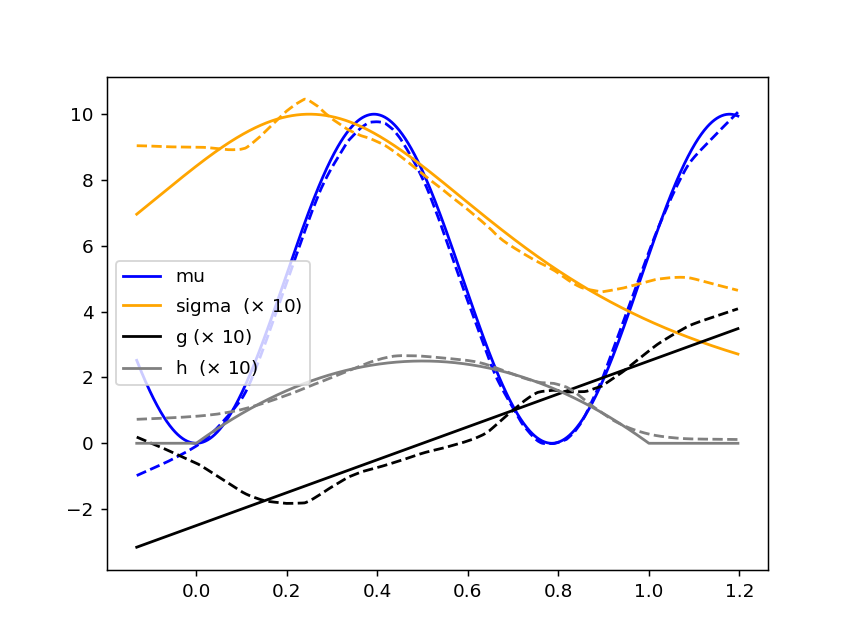

In [6]:
x_plot = np.linspace(min(x_data), max(x_data), 1000).astype(np.float32)
x_plot = x_plot.reshape((-1, 1))
# true regressed values
mu, beta, g, h = f(x_plot)

# predict g-and-h distributions for x_plot values
nn.eval()
with torch.no_grad():
    theta_plot = loss.predict(nn(torch.from_numpy(x_plot)))

mu_hat, beta_hat, g_hat, h_hat = theta_plot

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, mu, color='blue', label='mu')
ax.plot(x_plot, mu_hat, color='blue', linestyle='--')

ax.plot(x_plot, 10 / beta, color='orange', label=r'sigma  ($\times$ 10)')
ax.plot(x_plot, 10 / beta_hat, color='orange', linestyle='--')

ax.plot(x_plot, 10 * g, color='k', label=r'g ($\times$ 10)')
ax.plot(x_plot, 10 *g_hat, color='k', linestyle='--')

ax.plot(x_plot, 10 * h, color='gray', label=r'h  ($\times$ 10)')
ax.plot(x_plot, 10 * h_hat, color='gray', linestyle='--')

ax.legend()

We now plot the true conditional distributions for 4 values of the feature $x$ (blue), the G-and-H distribution predicted by the neural network for these same 4 values of the feature (orange), and the Gaussian distributions predicted by a separate neural network trained for that purpose using negative Gaussian likelihood for the loss function (green)

<IPython.core.display.Javascript object>


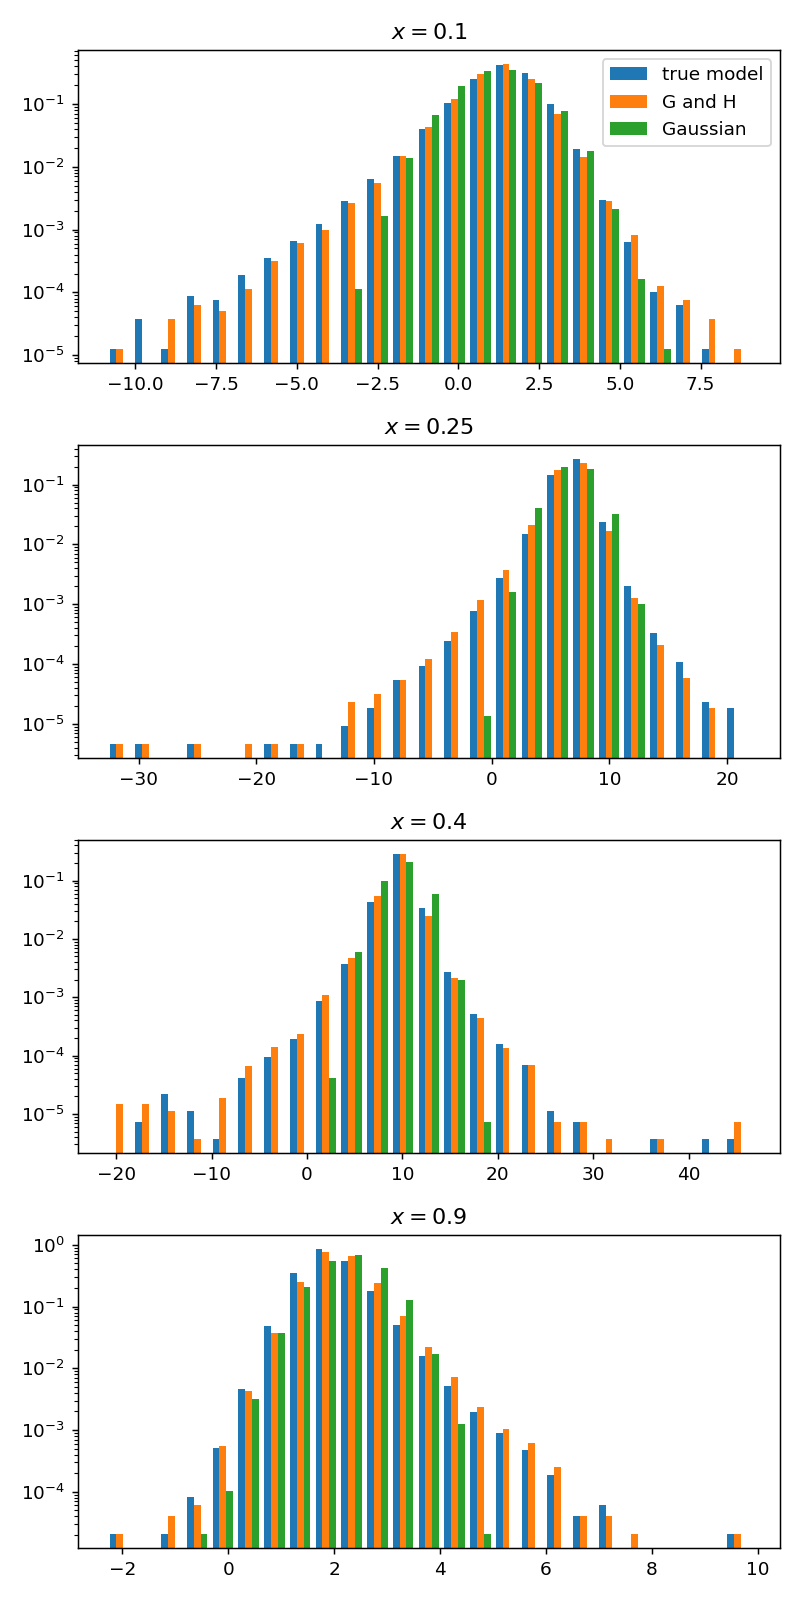

In [7]:
n_points = 100000
x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(6, 12))


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(4, 1, i + 1)
    x = x_0 * np.ones(n_points, dtype=np.float32).reshape((-1, 1))
    z = np.random.randn(n_points).reshape((-1, 1))
    z2 = np.random.randn(n_points).reshape((-1, 1))


    theta_true = f(x)
    with torch.no_grad():
        theta_pred = loss.predict(nn(torch.tensor(x).reshape((-1, 1))))
        theta_gaussian_pred = loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))
    y_true = tukey_g_h(z, theta_true)
    #y_true = t_dist(x.reshape((1, -1))).reshape((-1, 1))

    y_pred = tukey_g_h(z, theta_pred)
    y_gaussian_pred = theta_gaussian_pred[0] + 1 / theta_gaussian_pred[1] * z

    ax.hist(np.hstack((y_true, y_pred, y_gaussian_pred)), 
            bins=25, density=True, cumulative=False, log=True,
            label=('true model', 'G and H', 'Gaussian'))
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()

For a more rigurous analysis, we can compare the distribution of the $\hat{z}_i$'s to that of a standard normal.

In [8]:
import tukey.losses as ll

with torch.no_grad():
    theta_hat = loss.predict(nn(torch.from_numpy(x_data_val.reshape((-1, 1)))))
    mu, beta, g, h = theta_hat
    z_tilda = (torch.from_numpy(y_data_val.reshape((-1, 1))) - mu) * beta
    z_hat = ll.Tuckey_g_h_inverse.forward(None, z_tilda, g, h)

z_hat = z_hat.numpy()

<IPython.core.display.Javascript object>


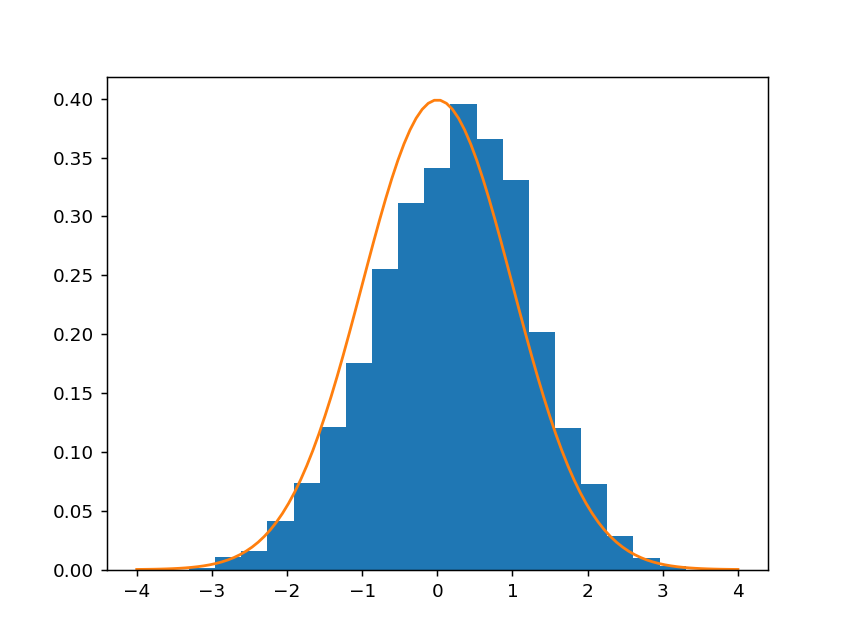

In [9]:
from scipy.stats import norm

plt.figure()
plt.hist(z_hat, bins=np.linspace(-4, 4, 24), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)))

We do a QQ plot to compare to the standard normal distribution.

<IPython.core.display.Javascript object>


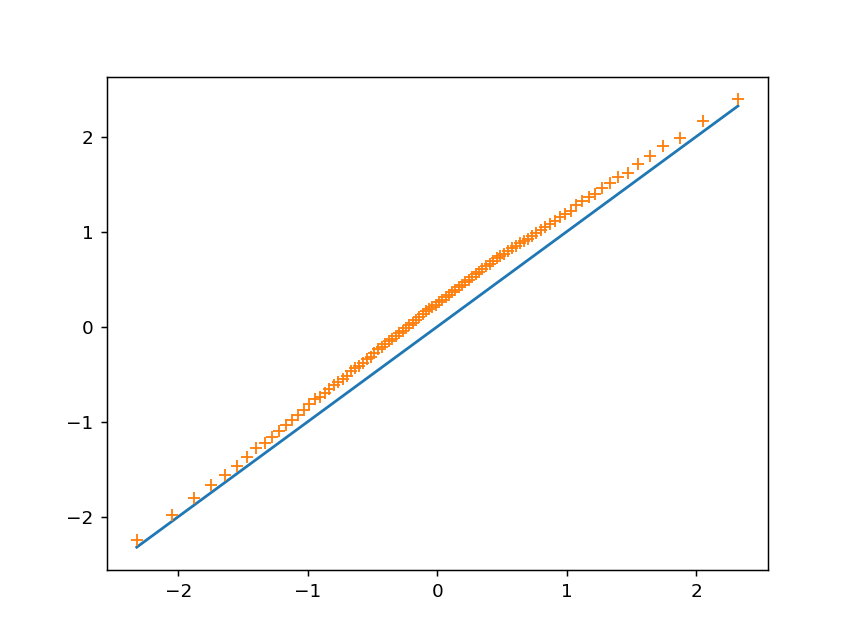

In [10]:
q = np.linspace(0, 1, 100)[1: -1]
true_quantiles = norm.ppf(q)
data_quantiles = np.quantile(z_hat, q)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(true_quantiles, true_quantiles)
ax.plot(true_quantiles, data_quantiles, '+')

## Prediction confidence intervals 

One can easily obtain prediction confidence intervals from the trained neural network (even though these are not as rigurous as prediction confidence intervals understood in statistical terms, where one also accounts for the uncertainty in the parameter estimates - here this would correspond to the uncertainty in the parameters of the neural network, which could be approached by Bayesian NN or Bootstrapping??).

In [11]:
confidence_level = 0.5
x_plot = np.linspace(min(x_data), max(x_data), 256).astype(np.float32).reshape((-1, 1))

<IPython.core.display.Javascript object>


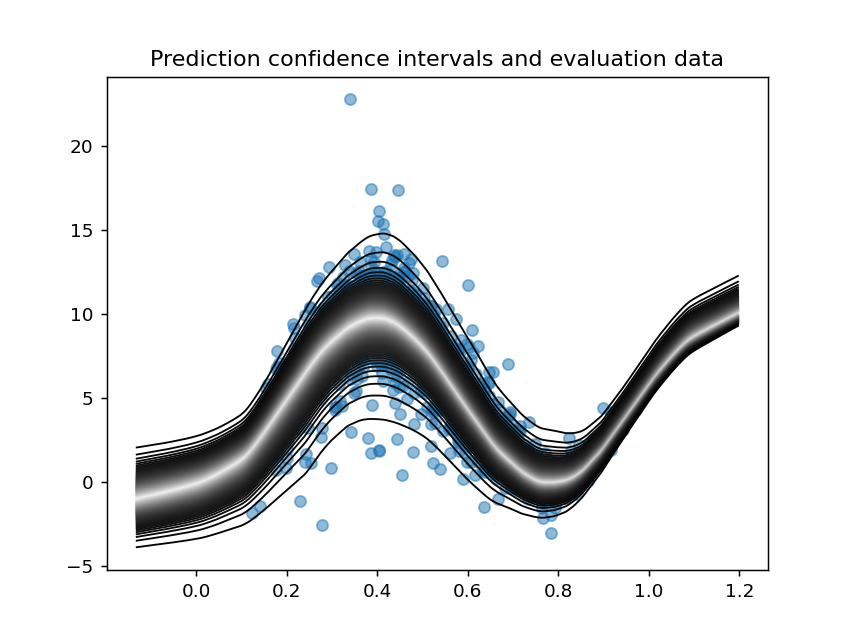

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [13]:
plt.figure()

for confidence_level in np.arange(0.01, 1, 0.01):
    with torch.no_grad():
        lb, ub = loss.predict_ci(nn(torch.from_numpy(x_plot)), confidence_level)
        lb = lb.numpy()
        ub = ub.numpy()
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

## Bootstrapping prediction confidence intervals 

Our prediction confidence intervals are not prediction confidence intervals in the usual statistical sense, as we do not account for the uncertainty in parameter estimates (here the parameters of the neural network).
One way we might approach this is via bootstrapping - we simulate new values using the fitted distributions, train the neural network on those new values.

In [14]:
import copy
n_boot = 10  # number of bootstrap neural networks
nn_boots = [] # list to keep references to bootstrap neural networks

for i_boot in range(n_boot):
    nn_boot = copy.deepcopy(nn)  # we start from the trained nn
    nn_boots.append(nn_boot)
    
    # simulate bootstrap data from the trained model
    nn.eval()
    with torch.no_grad():
        theta_hat = loss.predict(nn(torch.from_numpy(x_data).reshape((-1, 1))))
        theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

    x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
    dataset_boot = TensorDataset(x_torch, y_torch)
    
    # train the bootstrap neural network on bootstrap data
    for i_epoch in range(20):
        optimizer = Adam(nn_boot.parameters(), lr=1e-4)
        epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)

Train losses:  0.5620174856258866 0.7302034689268138
Validation losses:  0.626791856251657 0.7229546243324876
Train losses:  0.5612634286170953 0.7266895303595766
Validation losses:  0.5961355268955231 0.7277225144207478
Train losses:  0.5599219008099501 0.7263226041550583
Validation losses:  0.6231017271056771 0.7031750455498695
Train losses:  0.5606641281250478 0.7255191900940301
Validation losses:  0.6361991111189127 0.7185211330652237
Train losses:  0.5577499815048872 0.7239761653855129
Validation losses:  0.5863543041050434 0.7433956414461136
Train losses:  0.5624777837634871 0.7169890505691358
Validation losses:  0.6545523311942816 0.7459281422197819
Train losses:  0.5602416730575979 0.7246315744871941
Validation losses:  0.6103567499667406 0.7249590251594782
Train losses:  0.5611061137743865 0.7322715672762108
Validation losses:  0.5932865561917424 0.6989435749128461
Train losses:  0.5626111394864823 0.7242718439263625
Validation losses:  0.582169427536428 0.6995879178866744
Tra

Validation losses:  0.5929435659199953 0.730577738955617
Train losses:  0.5688995879667132 0.728293238520277
Validation losses:  0.6087924921885133 0.7194805331528187
Train losses:  0.5690682957419637 0.7250167963537679
Validation losses:  0.6412895796820521 0.7119445037096739
Train losses:  0.567223232124804 0.7291610298716528
Validation losses:  0.6304060174152255 0.7460432201623917
Train losses:  0.5660282915369023 0.727302100255504
Validation losses:  0.622530504129827 0.7098932676017284
Train losses:  0.566879221560452 0.7276418798284529
Validation losses:  0.6630776226520538 0.7219351921230555
Train losses:  0.5743496745921326 0.7361109866153384
Validation losses:  0.5936808548867702 0.7132692560553551
Train losses:  0.5720778264113746 0.7336695697968079
Validation losses:  0.5918374611064792 0.7181409504264593
Train losses:  0.5714089045208045 0.7330528820772034
Validation losses:  0.5944748353213072 0.7214691936969757
Train losses:  0.5719464902168007 0.7310499159668437
Validat

Train losses:  0.568982194109706 0.7448703051962855
Validation losses:  0.6186279281973839 0.7171915117651224
Train losses:  0.574081262616387 0.7441143094767484
Validation losses:  0.594522163271904 0.7104358449578285
Train losses:  0.5682406716076055 0.7436982795305404
Validation losses:  0.6105857975780964 0.7032555742189288
Train losses:  0.5709433788725061 0.7470665448186514
Validation losses:  0.6226972136646509 0.706800926476717
Train losses:  0.5694892133943453 0.7446584766573671
Validation losses:  0.653621219098568 0.7274375166743994
Train losses:  0.5694457664564049 0.7448286223913899
Validation losses:  0.5937339998781681 0.7132324632257223
Train losses:  0.5682475545168699 0.7443385993989508
Validation losses:  0.5946804052218795 0.708849597722292
Train losses:  0.5705793637336846 0.7447803253774238
Validation losses:  0.6089278729632497 0.7129294611513615
Train losses:  0.5694097712052839 0.742918297769379
Validation losses:  0.7523090485483408 0.72904397174716
Train loss

<IPython.core.display.Javascript object>


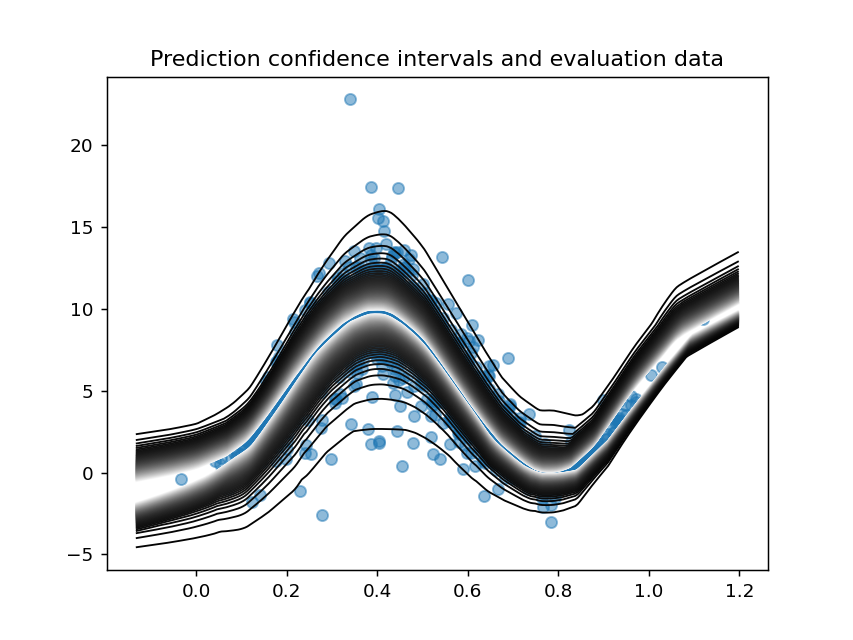

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [24]:
plt.figure()

for confidence_level in np.arange(0.01, 1, 0.01):
    lbs, ubs = [], []
    for nn_boot in nn_boots:
        with torch.no_grad():
            lb, ub = loss.predict_ci(nn_boot(torch.from_numpy(x_plot)), confidence_level)
            lb = lb.numpy()
            ub = ub.numpy()
        lbs.append(lb)
        ubs.append(ub)
    lbs = np.stack(lbs, axis=0)
    ubs = np.stack(ubs, axis=0)
    # currently we use the mean but incorrect
    lb = np.min(lbs, axis=0)
    ub = np.max(ubs, axis=0)
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

In [19]:
lbs.shape

(10, 256, 1)

In [23]:
ubs[:, 0, :]

array([[1.5144964],
       [1.4531951],
       [1.8890878],
       [1.8069704],
       [1.7692032],
       [1.2317342],
       [1.2510993],
       [1.6703963],
       [2.3466814],
       [1.6975589]], dtype=float32)

Here we define a proper class to implement the bootstrapped prediction confidence intervals

In [25]:
from torch.nn import Module

class Bootstrapped:
    def __init__(self, loss, trained_model: Module, n_bootstraps: int):
        self.loss = loss
        self.trained_model = trained_model
        self.n_bootstraps = n_bootstraps
        self.boot_models = []

    def generate_bootstrap_data(self, x_data: np.ndarray):
        """
        Generate bootstrap data using the passed features and the 
        conditional distributions corresponding to the trained neural
        network.
        """
        self.trained_model.eval()
        with torch.no_grad():
            x_data = torch.from_numpy(x_data).reshape((-1, 1))
            theta_hat = loss.predict(self.trained_model(x_data))
            theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

        x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
        dataset_boot = TensorDataset(x_torch, y_torch)
        return dataset_boot
    
    def train(self, x: np.ndarray):
        """
        Train the bootstrap neural networks on bootstrap data from
        the trained model.
        """
        for i_boot in range(self.n_bootstraps):
            nn_boot = copy.deepcopy(self.trained_model)  # we start from the trained nn
            self.boot_models.append(nn_boot)

            # simulate bootstrap data from the trained model
            dataset_boot = self.generate_bootstrap_data(x)

            # train the bootstrap neural network on bootstrap data
            for i_epoch in range(20):
                optimizer = Adam(nn_boot.parameters(), lr=1e-4)
                epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)
        
    def cumulative(self, x, y):
        """
        Provide the cumulative distribution function of predictions
        based on the bootstrapped neural networks.
        """
        raise NotImplementedError()

    def confidence_interval(self, x, level: float):
        """
        Provide prediction confidence intervals.
        """
        